In [1]:
import uproot
import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt

In [ ]:
root_file = uproot.open('../samples/vertexperformance_AMVF_pu100.root')

In [ ]:
root_file.keys()

In [ ]:
reco_tree = root_file['Reco_Vertex']
truth_tree = root_file['Truth_Vertex_PV_Selected']

In [ ]:
reco_array = reco_tree.arrays(library="np")
truth_array = truth_tree.arrays(library="np")

In [ ]:
def GetTrkTruthMatchInfo(reco_trk, truth_trk):
    return np.where(reco_trk.reshape(reco_trk.size, 1) == truth_trk)[1]

In [ ]:
trk_truth_idx = GetTrkTruthMatchInfo(reco_array['reco_vtx_fitted_trk_z0'][0], truth_array['truth_vtx_fitted_trk_z0'][0])

In [ ]:
trk_truth_vtx = truth_array['truth_vtx_fitted_trk_vtxID'][0][trk_truth_idx]

In [ ]:
reco_array['reco_vtx_fitted_trk_trackWeight'][0][np.where(trk_truth_vtx==0)].sum()

In [ ]:
reco_array['reco_vtx_fitted_trk_trackWeight'][0].sum()

In [ ]:
for reco_vtx_idx in range(reco_array['reco_vtx_fitted_trk_vtxID'][0].max()):
    reco_vtx_trk_idx = np.where(reco_array['reco_vtx_fitted_trk_vtxID'][0] == reco_vtx_id)[0]
    trk_truth_idx = GetTrkTruthMatchInfo(reco_array['reco_vtx_fitted_trk_z0'][0], truth_array['truth_vtx_fitted_trk_z0'][0])
    trk_truth_vtx = truth_array['truth_vtx_fitted_trk_vtxID'][0][trk_truth_idx[reco_vtx_trk_idx_0]]

In [ ]:
len(reco_array['reco_vtx_fitted_trk_vtxID'])

In [ ]:
# import warnings
# warnings.filterwarnings("error")

vxMatchWeight = 0.7
PV_Classification = np.zeros((4),int)

N_Event = len(reco_array['reco_vtx_fitted_trk_vtxID'])
# N_Event = 1
for event_id in range(N_Event):
    # event_id = 1134# event_id  debug use
    if event_id % 1000 == 0:
        print(f"{event_id} events processed.")
        
    trk_truth_idx = GetTrkTruthMatchInfo(reco_array['reco_vtx_fitted_trk_z0'][event_id], truth_array['truth_vtx_fitted_trk_z0'][event_id]) # get trk location in truth array 
    trk_truth_vtx = truth_array['truth_vtx_fitted_trk_vtxID'][event_id][trk_truth_idx]
    trk_reco_vtx = reco_array['reco_vtx_fitted_trk_vtxID'][event_id]
    trk_pt_sq = ((1./reco_array["reco_vtx_fitted_trk_qp"][event_id])*np.sin(reco_array["reco_vtx_fitted_trk_theta"][event_id]))**2

    n_truth_vtx = np.max(trk_truth_vtx)
    n_reco_vtx = np.max(trk_reco_vtx)

    Raw_RecoVertexMatchInfo = np.zeros((n_reco_vtx+1,n_truth_vtx+1, 2), dtype=float)
    for reco_vtx_id in range(n_reco_vtx+1):
        for truth_vtx_id in range(n_truth_vtx+1):
            matched_idx = np.intersect1d(np.where(trk_reco_vtx == reco_vtx_id)[0], np.where(trk_truth_vtx == truth_vtx_id)[0])

            if not matched_idx.any():
                continue 

            Raw_RecoVertexMatchInfo[reco_vtx_id, truth_vtx_id, 0]= reco_array['reco_vtx_fitted_trk_trackWeight'][event_id][matched_idx].sum()
            Raw_RecoVertexMatchInfo[reco_vtx_id, truth_vtx_id, 1]= trk_pt_sq[matched_idx].sum()

    RecoVertexMatchInfo = np.copy(Raw_RecoVertexMatchInfo)
    # RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=0)
    # try:
    #     RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=1)[:,np.newaxis]
    # except RuntimeWarning: 
    #     print(event_id)
        
    RecoVertexMatchInfo[:,:,0] = Raw_RecoVertexMatchInfo[:,:,0]/Raw_RecoVertexMatchInfo[:,:,0].sum(axis=1)[:,np.newaxis]
        
    assigned_type = np.array([-1]*(n_reco_vtx+1))
    for reco_vtx_id in range(n_reco_vtx+1):      
        if np.isnan(RecoVertexMatchInfo[:,:,0][reco_vtx_id]).all():
            assigned_type[reco_vtx_id] = 3 # labelled as fake 
            continue
            
        max_weight_idx = np.argmax(RecoVertexMatchInfo[:,:,0][reco_vtx_id])
        if RecoVertexMatchInfo[:,:,0][reco_vtx_id][max_weight_idx] > vxMatchWeight and RecoVertexMatchInfo[:,:,1][reco_vtx_id][max_weight_idx] == RecoVertexMatchInfo[:,:,1][:,max_weight_idx].max():
            assigned_type[reco_vtx_id] = 0 # labelled as matched/clean 
            # keep highest sumpt2 vertex labelled as matched/merged 
        elif RecoVertexMatchInfo[:,:,0][reco_vtx_id][max_weight_idx] < vxMatchWeight and RecoVertexMatchInfo[:,:,1][reco_vtx_id][max_weight_idx] == RecoVertexMatchInfo[:,:,1][:,max_weight_idx].max():
            assigned_type[reco_vtx_id] = 1 # labelled as merged
        else: 
            assigned_type[reco_vtx_id] = 2 # labelled as spilt 
            
            
    stat = np.bincount(assigned_type)
    for PV_type in range(len(stat)):
        PV_Classification[PV_type] += stat[PV_type]

In [11]:
PV_Classification_pu100

array([296829,  94206,  88536,  61504])

In [ ]:
np.save("PV_Classification_pu100",PV_Classification)

In [5]:
PV_Classification_pu100 = np.load("PV_Classification_pu100.npy")

In [13]:
PV_Classification_pu100/PV_Classification_pu100.sum()

array([0.54859123, 0.17410895, 0.16362981, 0.11367001])

In [15]:
PV_Classification_pu100/10000

array([29.6829,  9.4206,  8.8536,  6.1504])

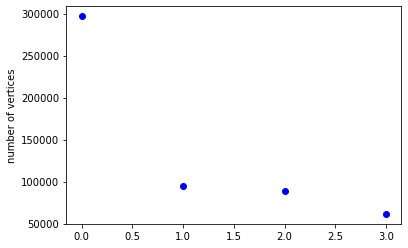

In [8]:
plt.plot(PV_Classification_pu100, 'bo')
plt.ylabel('number of vertices')
plt.show()

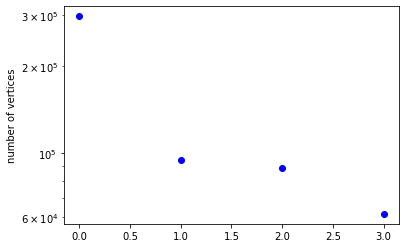

In [9]:
plt.plot(PV_Classification_pu100, 'bo')
plt.ylabel('number of vertices')
plt.yscale('log')
plt.show()
